In [1]:
import random
import numpy as np

import torch
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets
from torchvision.transforms import v2 as transforms_v2
from torchvision.io import decode_image

import hydra
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose

import dr_gen.utils.data as du
import dr_gen.utils.run as ru
import dr_gen.utils.viz as vu

%load_ext autoreload
%autoreload 2

### Setup Config & Helpers

In [2]:
with initialize(config_path=f"../scripts/conf/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
    )

In [3]:
print(OmegaConf.to_yaml(OmegaConf.to_container(cfg, resolve=True)))

train:
  run: true
  batch_size: 5
val:
  run: true
  batch_size: 10
eval:
  run: false
  batch_size: 10
seed: 101
paths:
  root: /Users/daniellerothermel/drotherm
  data: /Users/daniellerothermel/drotherm/data/dr_gen
  logs: /Users/daniellerothermel/drotherm/logs/dr_gen
  dataset_cache_root: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/
data:
  name: cifar10
  num_workers: 8
  cache_dataset: true
  download: true
  train:
    source: train
    source_percent: 0.8
    shuffle: true
    transform:
      normalize: true
      random_crop: true
      random_horizontal_flip: true
      color_jitter: true
      normalize_mean:
      - 0.4914
      - 0.4822
      - 0.4465
      normalize_std:
      - 0.2023
      - 0.1994
      - 0.201
      crop_size: 32
      crop_padding: 4
      random_horizontal_flip_prob: 0.5
      jitter_brightness: 0.247
  val:
    source: train
    source_percent: 0.2
    shuffle: false
    transform:
      normalize: true
      random_crop: false
      ran

In [4]:
generator = ru.set_deterministic(cfg.seed)

### Test out Dataloader

In [13]:
split_dls = du.get_dataloaders(cfg, generator)

Label: 6, Batch Shape: torch.Size([5, 3, 32, 32]), Total DS Len: 50000


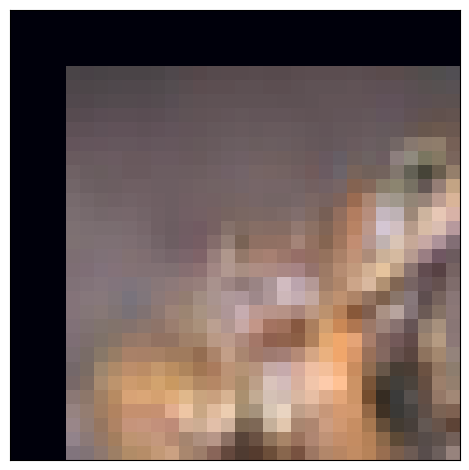

In [14]:
vu.plot_first_from_dl(split_dls['train'])

Label: 5, Batch Shape: torch.Size([10, 3, 32, 32]), Total DS Len: 10000


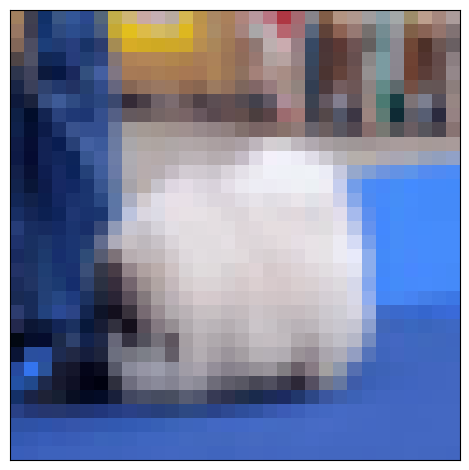

In [15]:
vu.plot_first_from_dl(split_dls['val'])

Label: 7, Batch Shape: torch.Size([10, 3, 32, 32]), Total DS Len: 10000


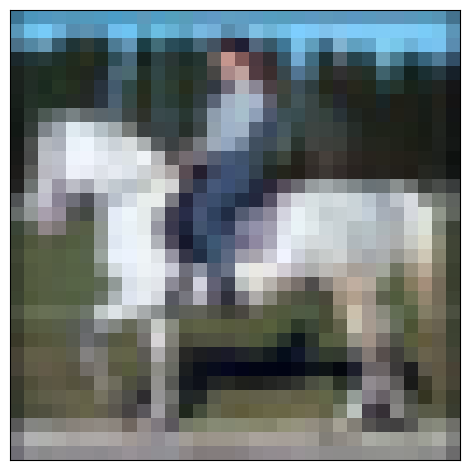

In [16]:
vu.plot_first_from_dl(split_dls['eval'])